In [1]:
import matlab.engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict
from IPython.display import clear_output
import math

eng = matlab.engine.start_matlab()

In [2]:
year = 2003
month = 2
day = 10
hour = 0
minute = 0
second = 0

startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day, hour+23, minute+59, second+59]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day, hour+23, minute+59, second+59)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=[]

for x in allMatData:
    allStationCodes.append(x[1][0])
    

In [3]:
%%time
for st in allStationCodes: 
    try:
        stationsOut[st] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(st))
    except:
        stationsNonexistentInFolder.append(st)

CPU times: user 379 ms, sys: 50.4 ms, total: 430 ms
Wall time: 3.04 s


In [4]:
def IndicatorCalculation(dataSt, timeshift, currentDate):
    
#     a1=np.float32(dataSt.get("a1")[timeshift])
#     x=np.float32(dataSt.get("x")[timeshift])
    x1=np.float32(dataSt.get("x1")[timeshift])
#     x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
    y=np.float32(dataSt.get("y")[timeshift])
    y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
    z1=np.float32(dataSt.get("z1")[timeshift])
    stLongeo=np.float32(dataSt.get("longeo"))
    stLatgeo=np.float32(dataSt.get("latgeo"))
    stAlt=np.float32(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    
    ratio = (((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/b[3])-1)*100
#     indicator = gaussian(ratio, 1, 0)
    return np.round(y,10)

In [5]:
%%time
stationIndicatorVariation.clear()
timeBetweenValues = 1
dataResolution = 0
dataBeforeNormalizaton = np.array([])
st = "clf"
delta = endDate-startDate
totalMinutes = (delta.total_seconds()+1)/60
for i in range(0, np.int16(totalMinutes+1), timeBetweenValues):
    try:
        update = datetime.timedelta(minutes=i)
        currentDate = startDate+update
        stationIndicatorVariation[st].append(float(IndicatorCalculation(stationsOut.get(st), i, currentDate)))
    except:
        None

CPU times: user 1.76 s, sys: 131 ms, total: 1.89 s
Wall time: 3.12 s


In [6]:
normalized01StationIndicatorVariation = defaultdict(list)

def NormalizeData01():
    for st in allStationCodes:
        for i in range(0, len(stationIndicatorVariation[st])):
            normalized01StationIndicatorVariation[st].append((stationIndicatorVariation[st][i] - np.min(stationIndicatorVariation[st])) / (np.max(stationIndicatorVariation[st]) - np.min(stationIndicatorVariation[st])))

NormalizeData01()

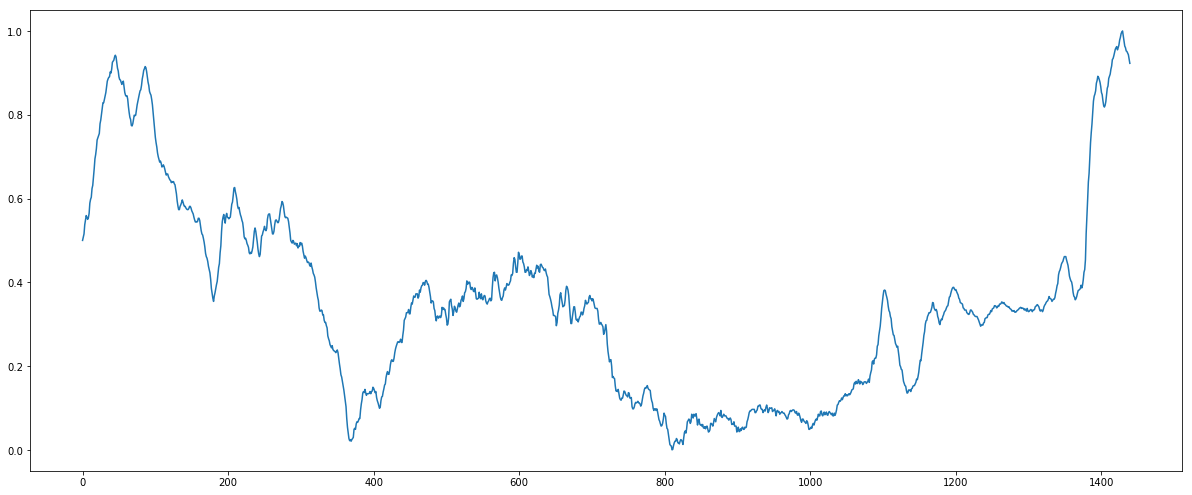

In [62]:
y = np.array(normalized01StationIndicatorVariation["clf"])
x = np.arange(0, 1440, timeBetweenValues)
fig= plt.figure(figsize=(20,8))
axes= fig.add_axes([0.8,0.8,0.8,0.8])
axes.plot(x,y)
plt.show()

In [76]:
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

parameters = {'kernel':['rbf'], 'gamma': [1e-3, 1e-2, 0.01, 0.1, 0.5, 0.9],'C': [1, 10, 50, 100, 1000, 1e4, 1e5]}
svr = GridSearchCV(SVR(), parameters)
# y = np.array(normalized01StationIndicatorVariation["clf"])
# x = np.arange(0,y.shape[0],1)
predictionGap = np.array([])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, shuffle=True)



def RemoveDataRandomly(x,y):
    rand = np.array([])
    r=0
    for i in range(0,y.shape[0]/2):
        while r in rand:
            r = random.randint(0,y.shape[0])
        rand = np.append(rand, r)

    for i in range(0,rand.shape[0]):
        y_train[np.int16(rand[i])] = np.nan
        
        
def RemoveDataGap(start, end):
    global predictionGap
    
    for i in range(start, end, 1):
        for y in range(0, X_train.shape[0]):
            if i == X_train[y]:
                y_train[y] = np.nan
                predictionGap = np.append(predictionGap,X_train[y])
        
# RemoveDataRandomly()
RemoveDataGap(400,500)

In [77]:
X_train = X_train.reshape(X_train.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1) 
X_test = X_test.reshape(X_test.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

X_train, y_train = RemoveInfNan(X_train, y_train)

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  from ipykernel import kernelapp as app
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


('score', 0.917470501456611)
Parameters tuning finished, best params: {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
MSE - 0.0813857039222


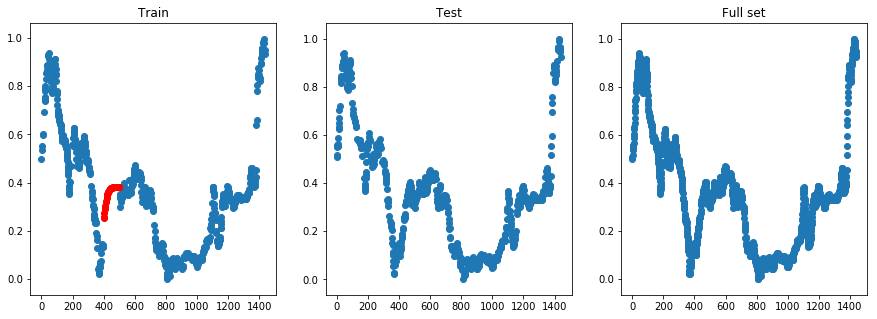

In [78]:
svr.fit(X_train, y_train)
print('score',svr.score(X_test.reshape(X_test.shape[0],1), y_test.reshape(y_test.shape[0],1)))

modelBestParams = svr.best_params_
print ("Parameters tuning finished, best params: {}".format(modelBestParams))


svr_rbf = SVR(kernel='rbf', C=modelBestParams['C'], gamma=modelBestParams['gamma'])
SVRmodel = svr_rbf.fit(X_train, y_train)


y_true = np.array([])
y_pred = SVRmodel.predict(predictionGap.reshape(predictionGap.shape[0], 1))
for i in range(0,predictionGap.shape[0]):
    y_true = np.append(y_true, y[np.int16(predictionGap[i])])

print("MSE - {}".format(mean_absolute_error(y_true, y_pred)))

ShowTrainTestSplit(predictionGap, y_pred)

In [94]:
# afterPrediction = np.full((y.shape[0],1), np.nan)
# afterPrediction[:] = y

# for i in range(0,y.shape[0]):
#     if math.isnan(afterPrediction[i]): 
#         afterPrediction[i] = SVRmodel.predict(i)
# x = np.arange(0,y.shape[0],1)      
# plt.scatter(x,afterPrediction)
# plt.savefig('plot.png')

In [95]:
# np.savetxt("afterPrediction2003.csv", afterPrediction, delimiter=",")

In [12]:
from sklearn.svm import SVR

def SupportVectorRegression(latValues, indicatorValues,params):
    svr_rbf = SVR(kernel='rbf', C=params['C'], gamma=params['gamma'])
    SVRmodel = svr_rbf.fit(latValues, indicatorValues)
    
    return SVRmodel


def RemoveInfNan(latValues, indicatorValues):
    indexDeleteY = np.array([])
    for i in range(0, indicatorValues.shape[0]):
        if math.isinf(indicatorValues[i]) or math.isnan(indicatorValues[i]):
            indexDeleteY = np.append(indexDeleteY, i)
    newY = np.delete(indicatorValues, indexDeleteY)
    newX = np.delete(latValues, indexDeleteY)
    newY=newY.reshape(newY.shape[0],1)
    newX=newX.reshape(newY.shape[0],1)
    
    return newX, newY

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def ParametersTuning():  
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.scatter(X_train, y_train)
#     ax2.scatter(X_test, y_test)
#     fig.set_size_inches(15,5)
    parameters = {'kernel':['rbf'], 'gamma': [1e-3, 1e-2, 0.01, 0.1, 0.5, 0.9],'C': [1, 10, 50, 100, 1000, 1e4, 1e5]}
    svr = GridSearchCV(SVR(), parameters)
    svr.fit(X_train, y_train)
    print('score',svr.score(X_test.reshape(X_test.shape[0],1), y_test.reshape(y_test.shape[0],1)))
    modelBestParams = svr.best_params_
    print ("Parameters tuning finished, best params: {}".format(modelBestParams))
    return modelBestParams

In [68]:
def ShowTrainTestSplit(xAxis,yAxis):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.scatter(X_train, y_train)
    ax1.scatter(xAxis,yAxis, color='red')
    ax2.scatter(X_test, y_test)
    ax1.title.set_text('Train')
    ax2.title.set_text('Test')
    ax3.scatter(x,y)
    ax3.title.set_text('Full set')
    fig.set_size_inches(15,5)